In [2]:
# import packages
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano

In [5]:
# load data 
d = pd.read_csv("../data/hh_budget.csv")
d.columns

Index(['Country', 'Year', 'Debt', 'DI', 'Expenditure', 'Savings', 'Wealth',
       'Unemployment'],
      dtype='object')

<AxesSubplot:xlabel='Year', ylabel='Wealth'>

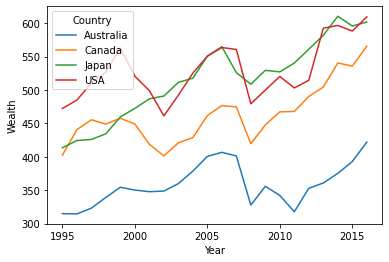

In [6]:
# first plot 
sns.lineplot(data = d, x = "Year", y = "Wealth", hue = "Country")

In [20]:
d["idx"] = pd.Categorical(d.Country).codes
d["traincode"] = pd.Categorical(d.Year).codes

In [21]:
# test & train split 
test = d[d["Year"] >= 2012]
train = d[d["Year"] < 2012]

In [22]:
 ## now all countries
# train data
idx_train = train.idx.values
year_train = train.traincode.values # necessary. 
wealth_train = train.Wealth.values

# test data
idx_test = test.idx.values
year_test = test.traincode.values
wealth_test = test.Wealth.values


In [23]:
N = len(np.unique(idx_train))

In [25]:
# pooled model
with pm.Model() as m0: 
    
    # hyper-priors
    α_μ = pm.Normal('α_μ', mu=400, sd=20)
    α_σ = pm.HalfNormal('α_σ', 10)
    β_μ = pm.Normal('β_μ', mu=20, sd=5)
    β_σ = pm.HalfNormal('β_σ', sd=10)
    
    # priors
    α = pm.Normal('α', mu=α_μ, sd=α_σ, shape=N)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=N)
    ε = pm.HalfCauchy('ε', 5)
    
    # containers 
    year_ = pm.Data('year', year_train) #Year_ as data container (can be changed). 
    idx_ = pm.Data('idx', idx_train)
    
    y_pred = pm.Normal('y_pred',
                       mu=α[idx_] + β[idx_] * year_,
                       sd=ε, observed=wealth_train)
    
    # trace 
    m0_trace = pm.sample(2000, return_inferencedata = True,
                        target_accept = .99)
    m0_prior = pm.sample_prior_predictive(samples=50) # just for model check. 
    m0_ppc = pm.sample_posterior_predictive(m0_trace, 
                                            var_names = ["α", "β", "y_pred"]) # still just for model check.
    #m0_saved = pm.save_trace(m0_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α, β_σ, β_μ, α_σ, α_μ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 39 seconds.


array([[<AxesSubplot:title={'center':'α_μ'}>,
        <AxesSubplot:title={'center':'α_μ'}>],
       [<AxesSubplot:title={'center':'β_μ'}>,
        <AxesSubplot:title={'center':'β_μ'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'α_σ'}>,
        <AxesSubplot:title={'center':'α_σ'}>],
       [<AxesSubplot:title={'center':'β_σ'}>,
        <AxesSubplot:title={'center':'β_σ'}>],
       [<AxesSubplot:title={'center':'ε'}>,
        <AxesSubplot:title={'center':'ε'}>]], dtype=object)

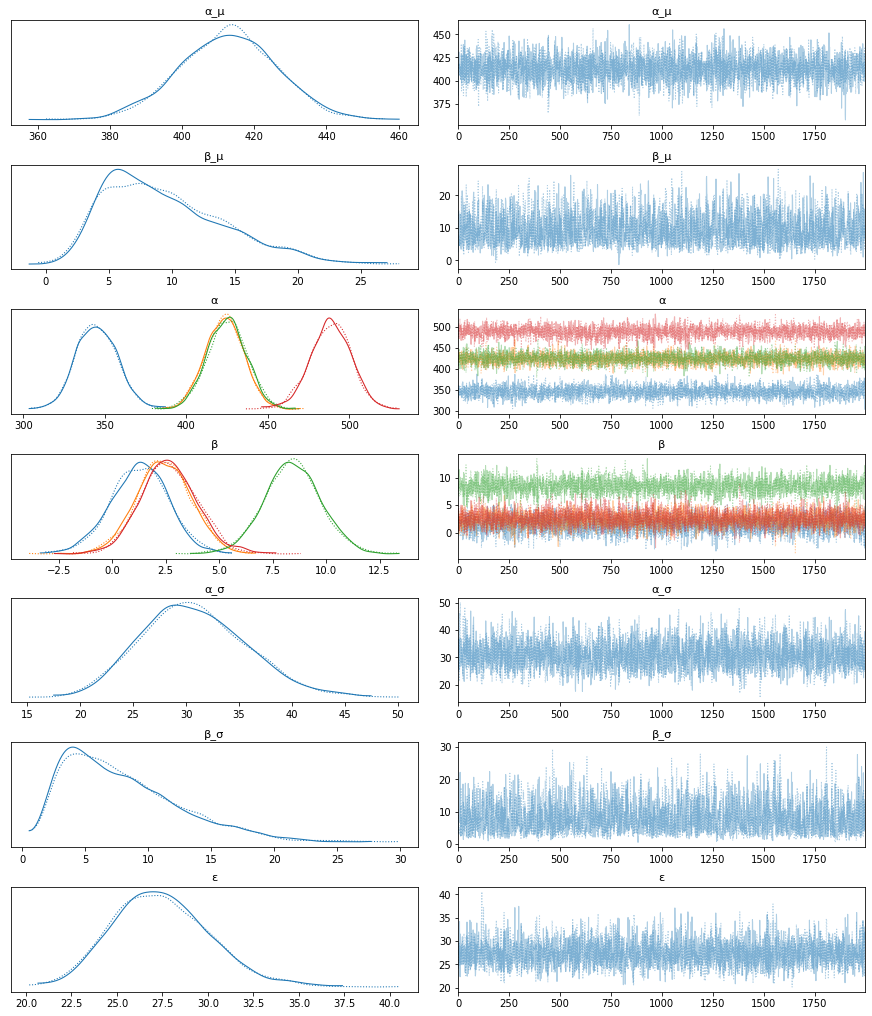

In [26]:
# az.summary(mod1_trace)
az.plot_trace(m0_trace)

In [ ]:
# 
_, ax = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, M
x_range = np.linspace(Year_train.min(), Year_train.max(), 10)
for i in range(N):
    ax[i].scatter(Year_train[j:k], Wealth_train[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = mod1_trace['α'][:, i].mean()
    beta_m = mod1_trace['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(Year_train.min()-1, Year_train.max()+1)
    plt.ylim(Wealth_train.min()-1, Wealth_train.max()+1)
    j += M
    k += M


In [ ]:
with m0: 
    pm.set_data({'Year_aust': Year_test_aust})
    m0_pred = pm.sample_posterior_predictive(m0_trace, var_names = ["α", "β", "y_pred"])

In [ ]:
pred = m0_pred["y_pred"]

In [ ]:
# plot predictions
y_mean = pred.mean(axis=0)
y_std = pred.std(axis=0)
plt.figure(figsize=(16, 8))
plt.scatter(Year_train_aust, Wealth_train_aust, c='k', zorder=10, label='Data')
plt.scatter(Year_test_aust, Wealth_test_aust, c="red", label='Held-out')
plt.plot(Year_test_aust, y_mean, label='Prediction Mean')
plt.fill_between(Year_test_aust, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
#plt.ylim(-14, 16)
plt.legend(loc='upper left')

In [ ]:
alpha = np.random.choice(m0_pred["α"], size = 50)
beta = np.random.choice(m0_pred["β"], size = 50)

In [ ]:
# get predictions as draws instead. 
# should be incorporated in the above function
# https://docs.pymc.io/notebooks/posterior_predictive.html
_, ax = plt.subplots()

for a, b in zip(alpha, beta):
    y = a + b * Year_test_aust
    ax.plot(Year_test_aust, y, c="k", alpha=0.4)

In [ ]:
# put it together in function
# would be nice to have it as prediction intervals instead of standard deviations. 
def plot_pred(trace, x_train, x_test, y_train, y_test, lines = True, size = 50, std = 3):
    
    ## main part
    pred = trace["y_pred"] # should not be hard-coded of course. 
    pred_mean = pred.mean(axis=0)
    pred_std = pred.std(axis=0)
    plt.figure(figsize=(16, 8))
    plt.scatter(x_train, y_train, c='k', zorder=10, label='Data')
    plt.scatter(x_test, y_test, c="red", label='Held-out')
    plt.plot(x_test, pred_mean, label='Prediction Mean', linewidth = 5, c = "k")
    plt.fill_between(Year_test_aust, pred_mean - std*pred_std, pred_mean + std*pred_std, 
                     alpha=0.2, label='Uncertainty Interval ($\mu\pm3\sigma$)')
    
    ## optionally add lines
    if lines == True: 
        
        # should take a pair. (randomize index).
        alpha = np.random.choice(trace["α"], size = size)
        beta = np.random.choice(trace["β"], size = size)
        
        for a, b in zip(alpha, beta):
            y = a + b * Year_test_aust
            plt.plot(Year_test_aust, y, c="k", alpha=0.4)
    
    ## final stuff
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left')

In [ ]:
plot_pred(m0_pred, Year_train_aust, Year_test_aust, 
         Wealth_train_aust, Wealth_test_aust)

In [ ]:
# Mean square error
y_mean = pred.mean(axis=0) # recall this 

# mean squared error (implement more) 
def MSE_fun(y_true, y_pred): 
    MSE = np.square(np.subtract(y_true, y_pred)).mean() 
    return MSE 

MSE1 = MSE_fun(Wealth_test_aust, y_mean)

In [ ]:
# get residuals 
def get_resid(y_true, y_pred): 
    error = [(true - pred) for true, pred in zip(y_true, y_pred)]
    return(error)

res_err = get_resid(Wealth_test_aust, y_mean)

In [ ]:
# one way of plotting (distplot)
sns.distplot(res_err)
#plt.hist(res_err)

In [ ]:
res_err

In [ ]:
# time residuals (over time). 
plt.scatter(x = Year_test_aust, y = res_err)
plt.plot(Year_test_aust, res_err)
plt.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
          colors = "black", linestyles = "dashed")

In [ ]:
# ACF (autocorrelation) of residuals
# pacf (partial) also exists (cool?)
from statsmodels.tsa.stattools import acf
acf_resid = acf(res_err) # perhaps some time-window? (the first will always be 1?)
acf_resid

In [ ]:
# plot
plt.scatter(x = Year_test_aust, y = acf_resid)
plt.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
          colors = "black", linestyles = "dashed")

In [ ]:
# plot them together (lige gg_tsresiduals)
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
# https://matplotlib.org/stable/tutorials/intermediate/gridspec.html
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0:]) # the whole upper. 
f_ax2 = fig.add_subplot(spec[1, 0])
f_ax3 = fig.add_subplot(spec[1, 1])

# first plot
f_ax1.scatter(x = Year_test_aust, y = res_err)
f_ax1.plot(Year_test_aust, res_err)
f_ax1.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
             colors = "black", linestyles = "dashed")

# second plot --> needs correction
f_ax2.scatter(x = Year_test_aust, y = acf_resid)
f_ax2.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
             colors = "black", linestyles = "dashed")

# third plot
f_ax3.hist(res_err, bins = len(res_err))


In [ ]:
# four plots instead (should be more straight forward)
# make this flexible and nice. 
def res_plot(trace, x_train, x_test, y_train, y_test, lines = True, size = 50, std = 3):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # first plot
    ## main part
    pred = trace["y_pred"] # should not be hard-coded of course. 
    pred_mean = pred.mean(axis=0)
    pred_std = pred.std(axis=0)
    axes[0, 0].scatter(x_train, y_train, c='k', zorder=10, label='Data')
    axes[0, 0].scatter(x_test, y_test, c="red", label='Held-out')
    axes[0, 0].plot(x_test, pred_mean, label='Prediction Mean', linewidth = 5, c = "k")
    axes[0, 0].fill_between(Year_test_aust, pred_mean - std*pred_std, pred_mean + std*pred_std, 
                     alpha=0.2, label='Uncertainty Interval ($\mu\pm3\sigma$)')

    ## optionally add lines
    if lines == True: 

        alpha = np.random.choice(trace["α"], size = size)
        beta = np.random.choice(trace["β"], size = size)

        for a, b in zip(alpha, beta):
            y = a + b * Year_test_aust
            axes[0, 0].plot(Year_test_aust, y, c="k", alpha=0.4)
    
    axes[0, 0].set_xlabel("x")
    axes[0, 0].set_ylabel("y")
    
    # second plot
    axes[0, 1].scatter(x = Year_test_aust, y = res_err)
    axes[0, 1].plot(Year_test_aust, res_err)
    axes[0, 1].hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
                      colors = "black", linestyles = "dashed")
    
    axes[0, 1].set_xlabel("time unit")
    axes[0, 1].set_ylabel("residuals")
    
    # third plot
    axes[1, 0].scatter(x = Year_test_aust, y = acf_resid)
    axes[1, 0].hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
                      colors = "black", linestyles = "dashed")
    
    axes[1, 0].set_xlabel("lag[1]") # should be flexible (and we should be sure that it is lag = 1)
    axes[1, 0].set_ylabel("ACF")

    # fourth plot
    sns.distplot(res_err, ax = axes[1, 1]) # setting bins?

In [ ]:
res_plot(m0_pred, Year_train_aust, Year_test_aust, 
         Wealth_train_aust, Wealth_test_aust)